# Testing lepton universality

We are interested in quantifying the probability for the data to support several hypothesis:

   * _null_: this is the assumption of lepton universality, i.e., $B(W\rightarrow e) = B(W\rightarrow \mu) = B(W\rightarrow \tau)$
   * _alt 1_: in this case, lepton universality is violated only for third generation leptons, i.e., $B(W\rightarrow e) = B(W\rightarrow \mu) \neq B(W\rightarrow \tau)$
   * _alt 2_: in this case, none of the branching fractions are the same and lepton universality completly breaks down, i.e., $B(W\rightarrow e) \neq B(W\rightarrow \mu) \neq B(W\rightarrow \tau)$
   
To do this, we carry out the fit to data with the various assumptions and construct the likelihood ratios, $q$ so that we can determine $P(q|data)$.  To determine the p values we will need to first determine the correct pdf for $q$ which can be done by evaluating the fit on toy data constructed assuming the null hypothesis.  Assuming the usual asymptotic approximation applies, Wilk's theorem, the pdf for $q$ will be a $\chi^{2}_{n}$ distribution with $k=1(2)$ for alternative hypothesis 1(2).

In [1]:
## imports and configuration
%cd '/home/naodell/work/wbr/analysis'
#%load_ext autoreload

from functools import partial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import minimize
from tqdm import tqdm_notebook

import scripts.plot_tools as pt
import scripts.fit_helpers as fh
from nllfit.nllfitter import ScanParameters

np.set_printoptions(precision=3)
rc_params = {
             'figure.figsize': (10, 10),
             'axes.labelsize': 20,
             'axes.facecolor': 'white',
             'axes.titlesize':'x-large',
             'legend.fontsize': 20,
             'xtick.labelsize':18,
             'ytick.labelsize':18,
             'font.size':18,
             'font.sans-serif':['Arial', 'sans-serif'],
             'mathtext.sf':'Arial',
             'lines.markersize':8.,
             'lines.linewidth':2.5,
            }
matplotlib.rcParams.update(rc_params)

%connect_info

/home/naodell/work/wbr/analysis
{
  "shell_port": 39921,
  "iopub_port": 57669,
  "stdin_port": 36433,
  "control_port": 59913,
  "hb_port": 59477,
  "ip": "127.0.0.1",
  "key": "bb1c6485-378f2cb8a379ec0660b1fe25",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-896cf9d2-f244-4617-91a5-b22b6a160380.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


In [2]:
# configure, get the input data, and do any additional processing that is needed
input_dir  = f'local_data/templates/nominal/'
processes = ['ttbar', 't', 'ww', 'wjets', 'zjets_alt', 'diboson', 'fakes'] 
selections = [
              'ee', 'emu', 'mumu',  
              'mutau', 'etau', 
              'mu4j', 'e4j'
             ]

# initialize fit data
fit_data = fh.FitData(input_dir, selections, processes, process_cut=0.1)
params = fit_data._parameters
params_pre = fit_data.get_params_init().values.copy()
sample = {cat:fit_data.mixture_model(params_pre, cat) for cat in fit_data._model_data.keys()}

In [7]:
# set up fit configuration
# bounds
bounds = [(0.1, 0.12), (0.1, 0.12), (0.1, 0.12), (0.64, 0.7)]
bounds += [(0.16, 0.18), (0.16, 0.18), (0.64, 0.66)]
bounds += fit_data._nnorm*[(0.2, 1.5), ]
bounds += fit_data._nshape*[(-2, 2), ]

# minimizer options
step_sizes = 0.001*params['err_init']
step_sizes[:4] = 4*[1e-6,]
min_options = dict(#eps=1e-9, 
                   #xtol=1e-3, 
                   #ftol=1e-9, 
                   #stepmx=0.1, 
                   #maxCGit=50, 
                   #accuracy=1e-10,
                   maxfun=5e4,
                   disp=None
                  )
# configure the objective
mask = params['active'].values.astype(bool)
fobj = partial(fh.reduced_objective,
               params_fixed = params_pre,
               mask = mask.copy(),
               objective=fit_data.objective,
               do_mc_stat = False,
               data = None #asimov_data
              )


In [ ]:
# carry out fit for n trials with random offsets for templates
ntrials = 10
results = dict(null=[], alt1=[], alt2=[])
cost = dict(null=[], alt1=[], alt2=[])
for _ in tqdm_notebook(range(ntrials)):
    
    # generate toy dataset
    for category, rnums in fit_data._rnum_cache.items():
        fit_data._rnum_cache[category]= np.random.randn(rnums.size)
        sample[category] = fit_data.mixture_model(params_pre, category, randomize=True)
    
    # copy initial parameter values
    pinit = params_pre[mask].copy()
        
    # carry out fit for null hypothesis (lepton universality)
    fobj_null = partial(fh.objective_lu, objective = fobj, test_type=1)
    mask = np.ones(params_pre.size).astype(bool)
    mask[1:4] = False
    result_null = minimize(fobj_null, pinit[mask],
                           method  = 'L-BFGS-B', 
                           options = min_options,
                           bounds  = bounds[0:1] + bounds[4:],
                           args = (sample)
                          )

    print(' null : ', result_null.fun, result_null.x[0]*100)
    if result_null.success or result_null.status == 1:
        results['null'].append(result_null.x)
        cost['null'].append(result_null.fun)
    else:
        print(result_null)
        results['null'].append(np.nan)
        cost['null'].append(np.nan)
    
    # carry out fit for alt1
    fobj_alt = partial(fh.objective_lu, objective = fobj, test_type=2)
    mask[1] = True
    pinit[0:3] = result_null.x[0]
    pinit[3] = 1 - 3*result_null.x[0]
    pinit[4:] = result_null.x[1:]
    result_alt1 = minimize(fobj_alt, pinit[mask],
                           method  = 'L-BFGS-B', 
                           options = min_options,
                           bounds  = bounds[0:2] + bounds[4:],
                           args = (sample)
                          )

    print(' alt. 1: ', result_alt1.fun, result_alt1.x[:2]*100)
    if result_alt1.success or result_alt1.status == 1:
        results['alt1'].append(result_alt1.x)
        cost['alt1'].append(result_alt1.fun)
    else:
        print(result_alt1)
        results['alt1'].append(np.nan)
        cost['alt1'].append(np.nan)
        
    # carry out fit for alt2
    pinit[0:2] = result_alt1.x[0]
    pinit[2] = result_alt1.x[1]
    pinit[3] = 1 - pinit[:3].sum()
    pinit[4:] = result_alt1.x[2:]
    result_alt2 =  minimize(fobj, pinit,
                            method = 'L-BFGS-B', 
                            options = min_options,
                            bounds = bounds,
                            args   = (sample)
                           )

    print(' alt. 2: ', result_alt2.fun, result_alt2.x[:4]*100)
    if result_alt2.success or result_alt2.status == 1:
        results['alt2'].append(result_alt2.x)
        cost['alt2'].append(result_alt2.fun)
    else:
        results['alt2'].append(np.nan)
        cost['alt2'].append(np.nan)
        print(result)

 null :  198.8606713458696 10.754034556352753
 alt. 1:  193.33485364207021 [10.696 10.853]
 alt. 2:  193.25005328757936 [10.69  10.692 10.858 67.761]
 null :  222.7112423897991 10.740182067907385
 alt. 1:  215.30353209685097 [10.757 10.702]
 alt. 2:  215.05900574904064 [10.759 10.772 10.695 67.773]
 null :  220.64217574807344 10.805702135630055
 alt. 1:  216.96192139657867 [10.808 10.798]
 alt. 2:  216.69684044328295 [10.795 10.823 10.8   67.582]
 null :  193.02717504788217 10.819889719237139
 alt. 1:  187.85685074968842 [10.823 10.954]
 alt. 2:  187.68526558896875 [10.817 10.817 10.96  67.406]
 null :  268.7261970702531 10.772570723686155
 alt. 1:  260.7098349173255 [10.775 10.676]
 alt. 2:  260.48234991965876 [10.766 10.772 10.666 67.796]
 null :  186.3332002057566 10.775168184174987
 alt. 1:  184.9524984440072 [10.763 10.808]
 alt. 2:  184.94567477080903 [10.763 10.763 10.808 67.667]
 null :  250.1818375485719 10.823149375080266
 alt. 1:  246.96331138710025 [10.81  10.785]
 alt. 2: 

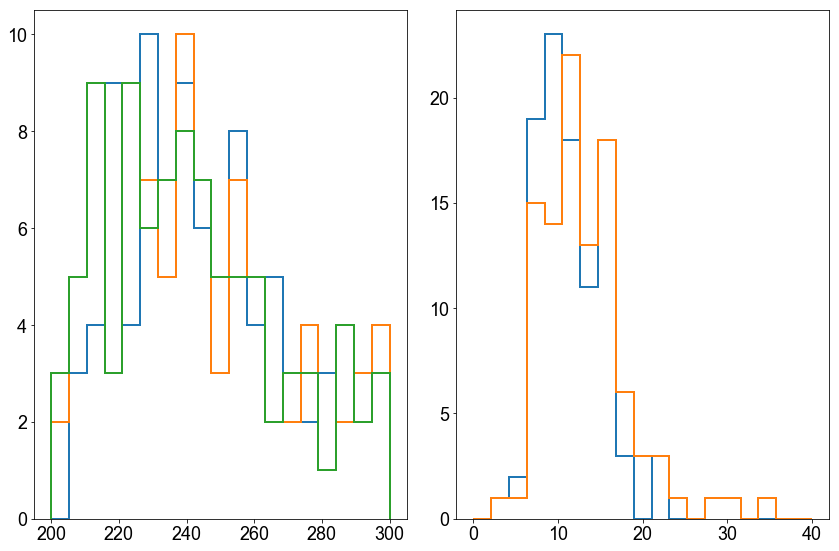

In [6]:
# plot costs

fig, axes = plt.subplots(1, 2, figsize=(12, 8), facecolor='white')

nll_null = np.array(cost['null'])
nll_alt1 = np.array(cost['alt1'])
nll_alt2 = np.array(cost['alt2'])

ax = axes[0]
bins = np.linspace(200, 300, 20)
ax.hist(cost['null'], bins, histtype='step', linewidth=2)
ax.hist(cost['alt1'], bins, histtype='step', linewidth=2)
ax.hist(cost['alt2'], bins, histtype='step', linewidth=2)

ax = axes[1]
bins = np.linspace(0, 40, 20)
q1 = 2*(nll_null - nll_alt1)
ax.hist(q1, bins, histtype='step', linewidth=2)
q2 = 2*(nll_null - nll_alt2)
ax.hist(q2, bins, histtype='step', linewidth=2)

plt.tight_layout()
plt.show()